# **Fashion MNIST Classification using Convolutional Neural Networks (CNNs)**

In this project, we use deep learning to classify images from the Fashion MNIST dataset, which contains 28x28 grayscale images of clothing items. The task is to build a Convolutional Neural Network (CNN) to accurately classify these images into one of 10 categories, such as shirts, sneakers, and dresses. We'll experiment with two CNN architectures—one simple and one improved using additional techniques like Batch Normalization and Dropout.

**Objectives:**

*   Implement a CNN for Fashion MNIST classification.
*   Improve the model using additional techniques.
*   Evaluate the model on training, validation, and test sets.
*   Visualize model performance in terms of loss and accuracy.

In [123]:
## Deep Learning Additional External Libraries
import torch
import torch.nn as nn                                               #nn will build the model
from torch import optim
import torchvision.transforms as T                                           #optim will reduce the loss
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tfs
from PIL import Image
from torchvision.datasets import FashionMNIST
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import os

### **Dataset:**
The Fashion MNIST dataset consists of:



*   60,000 training images and 10,000 test images.
*   Each image is a 28x28 pixel grayscale image associated with a label from 10 different classes:

  1. T-shirt/top
  2. Trouser
  3. Pullover
  5. Dress
  6. Coat
  7. Sandal
  8. Shirt
  9. Sneaker
  10. Bag
  11. Ankle boot

### Data Loading

In [115]:
# Hyperparameter (Feel Free to Change These, but Make Sure your Training Loop Still Works as Expected)
TRAIN_BATCH_SIZE = 50
VAL_BATCH_SIZE = 50
TEST_BATCH_SIZE = 1

# Transform data to PIL images
transforms = tfs.Compose([tfs.ToTensor(),
                          tfs.Normalize(mean=(0.5,),std=(0.5,))])

# Train/Val Subsets
train_mask = range(50000)
val_mask = range(50000, 60000)

# Download/Load Dataset
train_dataset = FashionMNIST('./data', train=True, transform=transforms, download=True)
test_dataset = FashionMNIST('./data', train=False, transform=transforms, download=True)

# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, sampler=SubsetRandomSampler(train_mask))
val_dataloader = DataLoader(train_dataset, batch_size=VAL_BATCH_SIZE, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

In [56]:
#Check if the FashionMNIST dataset is downloaded
data_dir = './data/FashionMNIST/raw/'
if os.path.exists(data_dir):
    print("Dataset downloaded successfully.")
else:
    print("Dataset not found.")

Dataset downloaded successfully.


In [57]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


here we can see one example image

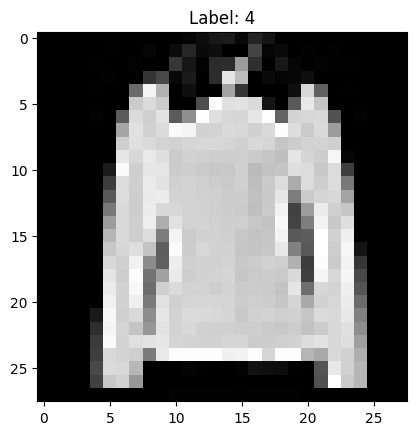

In [84]:
image, label = next(iter(train_dataloader))
plt.imshow(image[0, :].squeeze(), cmap='gray')
plt.title(f"Label: {label[0]}")
plt.show()

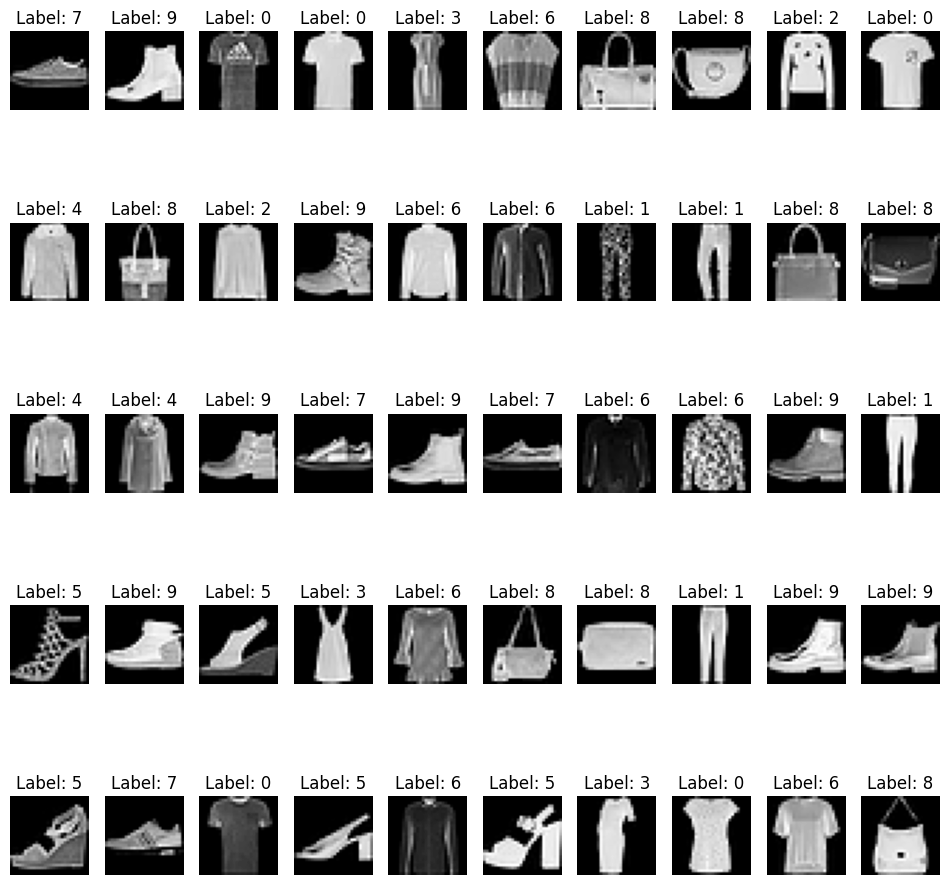

In [94]:
#Get one batch of images and labels
images, labels = next(iter(train_dataloader))
num_images = min(len(images), 50)                                          # Display up to 50 images


plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(5, 10, i + 1)                                              #adjust the grid size (5x10 in this case)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

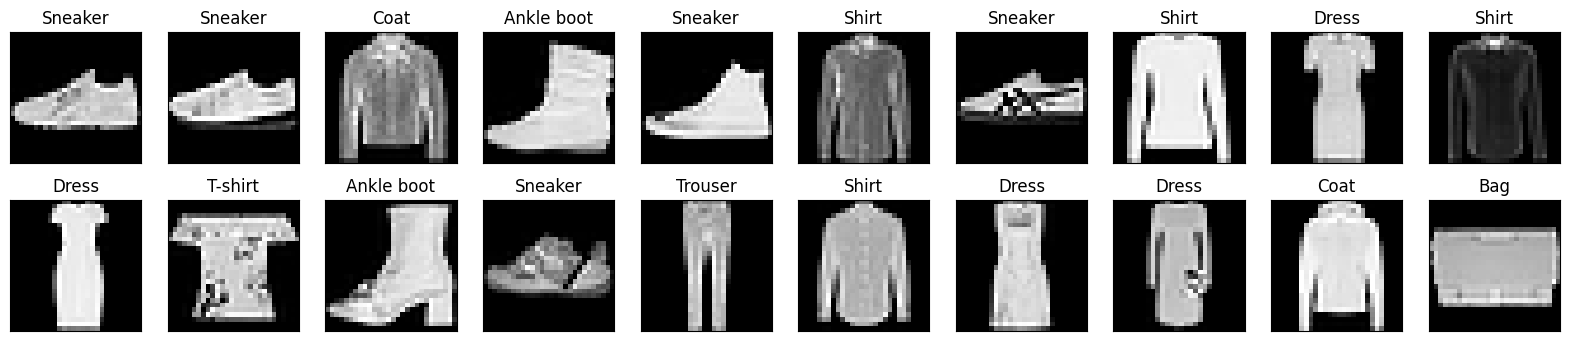

In [93]:
#list of class names
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig = plt.figure(figsize=(20, 4))
for idx in range(20):
    plt.subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(classes[labels[idx].item()])                                      #get the class name from the label

plt.show()

###Building the Model:
This model uses two convolutional layers followed by pooling, a fully connected layer, and a softmax output layer.

Model Architecture: <br>
* Input: 28x28 grayscale image.<br>
* Conv Layer 1: 32 filters, 3x3 kernel, followed by ReLU activation and 2x2 max pooling.<br>
* Conv Layer 2: 64 filters, 3x3 kernel, followed by ReLU activation and 2x2 max pooling.<br>
* Fully Connected Layer: 128 units with ReLU activation.<br>
* Output Layer: 10 units with softmax for classification.<br>

In [68]:
#definning the Architecture here
class CNNet(nn.Module):

    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                #Convolution+ ReLU+Pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)                           #adjusting the flattening step dynamically
        x = F.relu(self.fc1(x))                            #Activation Function
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)                         #sigmoid
        return x

GPU Installed

In [60]:
#!apt-get install cuda-toolkit-12-0

In [61]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [62]:
device

device(type='cuda')

### Training the Model
We trained this model using the Adam optimizer and CrossEntropy loss for 50 epochs.

In [63]:
for images, labels in train_dataloader:
    print(len(labels))
    break

50


In [64]:
#lets see how many images we have for train data
total_labels = 0
for images, labels in train_dataloader:
    total_labels += len(labels)
print(total_labels)

50000


In [69]:
def train(model,optimizer,loss,lr,epochs=50,train_dataloader=train_dataloader,val_dataloader=val_dataloader,test_dataloader=test_dataloader,**kwargs):

    train_losses = []
    val_accuracies = []
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in train_dataloader:

            images = images.to(device)                                          #move data to GPU
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            Loss = loss(outputs, labels)
            Loss.backward()
            optimizer.step()
            running_loss += Loss.item()

            #calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        #calculate average loss
        avg_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_loss)

        #validation step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:

                images = images.to(device)                                     #move data to GPU
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, 'f'Train Accuracy: {train_accuracy:.2f}%, 'f'Validation Accuracy: {val_accuracy:.2f}%')


    #evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:

            images = images.to(device)                                          #move data to GPU
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, val_accuracies

In [70]:
## Hyperparameters
EPOCH = 50
LR = 0.001

## Setting up the model, optimizer, and loss function
model = CNNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)     ## Adam optimizer
Loss =nn.CrossEntropyLoss()                                 ## Cross Entropy Loss

In [95]:
## Run Training Loop
train_losses, val_accuracies = train(model, optimizer, Loss, LR, epochs=EPOCH)

Epoch [1/50], Loss: 0.0161, Train Accuracy: 99.48%, Validation Accuracy: 91.76%
Epoch [2/50], Loss: 0.0153, Train Accuracy: 99.46%, Validation Accuracy: 91.80%
Epoch [3/50], Loss: 0.0145, Train Accuracy: 99.48%, Validation Accuracy: 91.55%
Epoch [4/50], Loss: 0.0154, Train Accuracy: 99.48%, Validation Accuracy: 91.59%
Epoch [5/50], Loss: 0.0133, Train Accuracy: 99.57%, Validation Accuracy: 91.81%
Epoch [6/50], Loss: 0.0174, Train Accuracy: 99.42%, Validation Accuracy: 92.18%
Epoch [7/50], Loss: 0.0133, Train Accuracy: 99.54%, Validation Accuracy: 91.51%
Epoch [8/50], Loss: 0.0132, Train Accuracy: 99.59%, Validation Accuracy: 91.61%
Epoch [9/50], Loss: 0.0133, Train Accuracy: 99.55%, Validation Accuracy: 91.98%
Epoch [10/50], Loss: 0.0132, Train Accuracy: 99.52%, Validation Accuracy: 91.90%
Epoch [11/50], Loss: 0.0111, Train Accuracy: 99.63%, Validation Accuracy: 91.66%
Epoch [12/50], Loss: 0.0138, Train Accuracy: 99.53%, Validation Accuracy: 91.61%
Epoch [13/50], Loss: 0.0107, Train Ac

### Results
After training, we plot the training loss and validation accuracy over the epochs.

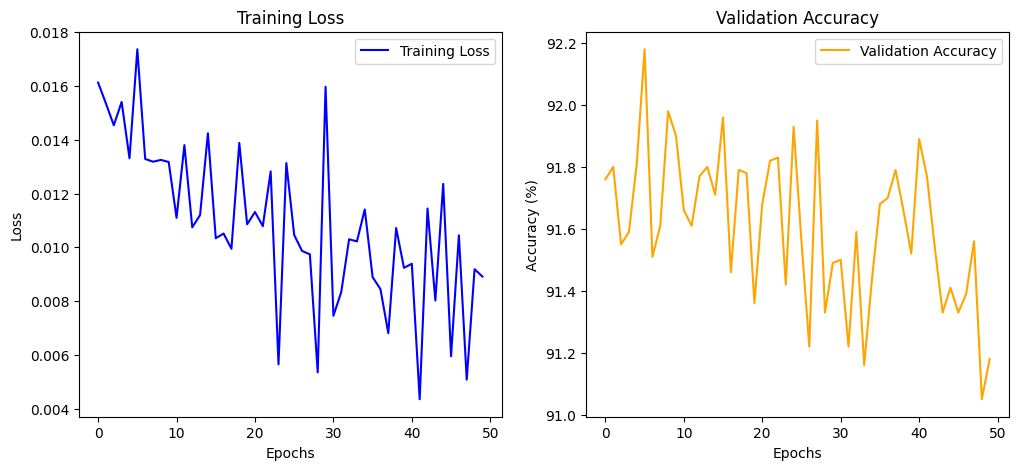

In [108]:
#plotting Training Loss and Validation Accuracy
plt.figure(figsize=(12, 5))

#plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### Make a single prediction

Predicted class: Ankle boot


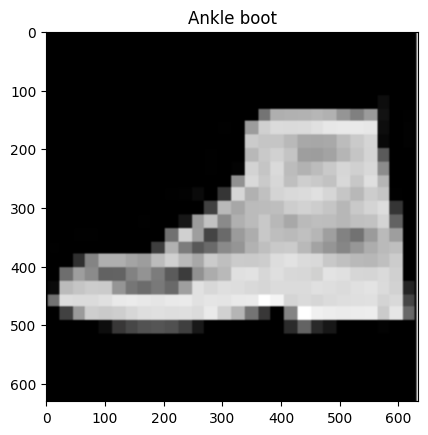

In [114]:
transform = T.Compose([
    T.Grayscale(),
    T.Resize((28, 28)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

#Load one sample image
img_path = '2.png'
image = Image.open(img_path)

img = transform(image).unsqueeze(0)                                   #transformation

if torch.cuda.is_available():
    img = img.cuda()                                                  #moving to GPU

#predict the class
with torch.no_grad():
    output = model(img)
    pred_class = torch.argmax(output, dim=1).item()

print(f'Predicted class: {classes[pred_class]}')


plt.imshow(image, cmap='gray')                                        #visualize the image with the predicted class
plt.title(classes[pred_class])
plt.show()

Now let try to improve the model using additional techniques. To improve performance, we can use Batch Normalization, Dropout, and an additional convolutional layer.


* Batch Normalization: Normalizes the inputs to each layer, improving training stability and potentially speeding up convergence.

* Dropout: Adds random noise to the network during training to prevent overfitting. Dropout rates of 25% for conv layers and 50% for fully connected layers are used.


### Again the Model Architecture
* Conv Layer 1: 32 filters, BatchNorm, ReLU, 2x2 max pooling, Dropout (25%).
* Conv Layer 2: 64 filters, BatchNorm, ReLU, 2x2 max pooling, Dropout (25%).
* Conv Layer 3: 128 filters, BatchNorm, ReLU, 2x2 max pooling, Dropout (25%).
* Fully Connected Layer: 128 units with ReLU, Dropout (50%).
* Output Layer: 10 units with softmax.

In [116]:
class CNNet2(nn.Module):

    def __init__(self):
        super(CNNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.25)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1152, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1- BN- ReLU -MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Model Training
Similar to the previous model, we use Adam optimizer and CrossEntropy loss again for 50 epochs. But now the learning rate is set to 0.0001 to adapt to the more complex architecture.

In [117]:
def train(model2,
          optimizer,
          loss,
          lr,
          epochs=50,
          train_dataloader=train_dataloader,
          val_dataloader=val_dataloader,
          test_dataloader=test_dataloader,
          **kwargs):

    train_losses = []
    val_accuracies = []

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        total_train = 0
        correct_train = 0
        for images, labels in train_dataloader:

            #Move data to the device
            images = images.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()
            outputs = model(images)
            Loss = loss(outputs, labels)
            Loss.backward()
            optimizer.step()
            running_loss += Loss.item()

            #calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        #calculate average loss
        avg_loss = running_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_loss)

        #validation step
        model2.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:
                # Move images and labels to the same device as the model
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, 'f'Train Accuracy: {train_accuracy:.2f}%, 'f'Validation Accuracy: {val_accuracy:.2f}%')

    #evaluate on the test set
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
           # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, val_accuracies

In [118]:
EPOCH = 50
LR = 0.0001

##again setting up the model, optimizer, and loss function
model2 = CNNet2().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LR)
Loss =nn.CrossEntropyLoss()

In [119]:
##run training Loop
train_losses, val_accuracies = train(model2, optimizer, Loss, LR, epochs=EPOCH)

Epoch [1/50], Loss: 0.6610, Train Accuracy: 77.97%, Validation Accuracy: 86.70%
Epoch [2/50], Loss: 0.3185, Train Accuracy: 88.29%, Validation Accuracy: 89.08%
Epoch [3/50], Loss: 0.2648, Train Accuracy: 90.50%, Validation Accuracy: 89.58%
Epoch [4/50], Loss: 0.2344, Train Accuracy: 91.51%, Validation Accuracy: 89.64%
Epoch [5/50], Loss: 0.2094, Train Accuracy: 92.36%, Validation Accuracy: 91.24%
Epoch [6/50], Loss: 0.1881, Train Accuracy: 93.18%, Validation Accuracy: 91.64%
Epoch [7/50], Loss: 0.1699, Train Accuracy: 93.82%, Validation Accuracy: 91.54%
Epoch [8/50], Loss: 0.1531, Train Accuracy: 94.54%, Validation Accuracy: 91.92%
Epoch [9/50], Loss: 0.1374, Train Accuracy: 95.09%, Validation Accuracy: 91.52%
Epoch [10/50], Loss: 0.1229, Train Accuracy: 95.68%, Validation Accuracy: 91.31%
Epoch [11/50], Loss: 0.1094, Train Accuracy: 96.23%, Validation Accuracy: 91.82%
Epoch [12/50], Loss: 0.0967, Train Accuracy: 96.59%, Validation Accuracy: 91.80%
Epoch [13/50], Loss: 0.0837, Train Ac

### Results

The improved model shows slightly better validation accuracy and a more stable loss curve compared to the previous model.

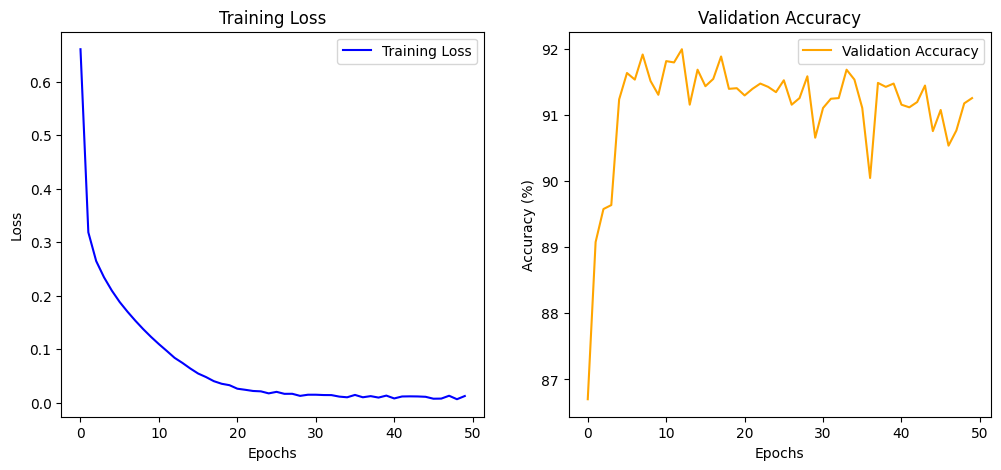

In [120]:
#training loss and validation accuracy
plt.figure(figsize=(12, 5))

#plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### Evaluation on Test Set
After training, we evaluate both models on the test set to measure their generalization performance.

CNN Model Test Accuracy: 90.1% <br>
CNN2 Model Test Accuracy: 91.37% <br>

The improved model shows slightly significant boost in performance, especially due to the addition of BatchNorm and Dropout layers.

### Conclusions

First CNN Model provides a solid baseline for Fashion MNIST classification, achieving reasonable accuracy with a simple architecture.

And then CNN2 Model significantly improves performance by using Batch Normalization and Dropout, which reduce overfitting and stabilize the training process.

Further improvements could be made by exploring more advanced architectures like ResNets or VGGs, or by performing hyperparameter tuning.